In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from skimage import feature

# 1. Load data 

Useful functions:

In [2]:
def load_image(infilename):
    """Read an image from a file to an array."""
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    """Convert image to 255 scale."""
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

def concatenate_images(img, gt_img):
    """Concatenate an image and its groundtruth."""
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    """Crop image in patches of width w and height h."""
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

def extract_features(img):
    """Extract 6-dimensional features consisting of average RGB color as well as variance."""
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

def extract_features_2d(img):
    """Extract 2-dimensional features consisting of average gray color as well as variance."""
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

def extract_img_features(filename, dim = '2d'):
    """Extract features for a given image."""
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    if dim == '2d':
        X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    else:
        X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])

    return X

def value_to_class(v, foreground_threshold):
    """Classify patch to a label according to threshold."""
    df = np.mean(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0
    
def label_to_img(imgwidth, imgheight, w, h, labels):
    """Create image from label vector."""
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    """Overlap image and predicted-label image."""
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

def print_eval(Y_train, Z_train, Y_test, Z_test): 
    print("Training set evaluation")
    print(classification_report(Y_train, Z_train))

    print("Testing set evaluation")
    print(classification_report(Y_test, Z_test))
    return 


Get training data and labels:

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)] 

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]


In [4]:
N_IMAGES_TRAIN = len(files)

Extract patches:

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [6]:
# foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
# X_train = X[0:len(X)//2]
# X_test = X[len(X)//2:len(X)]

# Y = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])
# Y_train = Y[0:len(X)//2]
# Y_test = Y[len(Y)//2:len(Y)]

# 2. Features extraction

Useful functions:

In [6]:
def create_feature_vectors(feat_img, w, h):
    """Create a feature vector of dimension w x h for each patch. Input feat_img is the image resulting of a feature extraction algorithm."""
    feat_patches = img_crop(feat_img, w, h)
    feat_vec = np.array([feat_patches[i].ravel() for i in range(len(feat_patches))])
    return feat_vec

def extract_img_extrafeatures(file, feat = 'hog'):
    """Create a feature vector of dimension w x h for each patch. """
    im = load_image(file)
    
    if feat == 'hog':
        hog_vec = []
        for j in range (3):
            v = feature.hog(im[:,:,j], orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), feature_vector = True).reshape((-1, 8))
            hog_vec.append(v)
        feat_vec = np.concatenate(hog_vec, axis=1)
    elif feat == 'lbp':
        feat_vec = create_feature_vectors(feature.local_binary_pattern(im[:,:,0], P = 8, R = 8), 16, 16)
    elif feat == 'canny':
        feat_vec = create_feature_vectors(feature.canny(im[:,:,0]), 16, 16)

    return feat_vec

### 2.1. Canny method: edge detection

In [7]:
plt.figure(figsize=(16,16))
fc=feature.canny(imgs[0][:,:,0])

# plt.subplot(1,2,1)
# plt.imshow(imgs[0]);
# plt.subplot(1,2,2)
# plt.imshow(fc, cmap='Greys_r');


<Figure size 1152x1152 with 0 Axes>

Create matrix of features $62500\times 256$ (256 edge-detection pixels for each patch):

In [8]:
canny_vec = create_feature_vectors(feature.canny(imgs[0][:,:,0]), 16, 16)*1 # convert bool to 0 and 1
for i in range(1, n):
    fc = feature.canny(imgs[i][:,:,0])
    canny_vec = np.vstack((canny_vec, create_feature_vectors(fc, 16, 16)))*1

### 2.2. Local Binary Pattern vector: texture classification


Joint distribution of the gray levels of P  equally spaced pixels on a circle of radius 􏰌R > 0􏰍 that form a circularly symmetric neighbor set.

In [9]:
plt.figure(figsize=(16,16))
fc=feature.local_binary_pattern(imgs[0][:,:,0],P = 8,R = 8) 

# plt.subplot(1,2,1)
# plt.imshow(imgs[0]);
# plt.subplot(1,2,2)
# plt.imshow(fc, cmap='Greys_r');

<Figure size 1152x1152 with 0 Axes>

Create matrix of features $62500\times 256$ (256 texture pixels for each patch):

In [10]:
lbp_vec = create_feature_vectors(feature.local_binary_pattern(imgs[0][:,:,0], P = 8, R = 8), 16, 16)/255 # scale to (0,1)
for i in range(1, n):
    fc = feature.local_binary_pattern(imgs[i][:,:,0], P = 8, R = 8)
    lbp_vec = np.vstack((lbp_vec, create_feature_vectors(fc, 16, 16)/255))

### 2.3. Histogram of oriented gradients:

It counts occurrences of gradient orientation in localized portions of an image.

In [11]:
plt.figure(figsize=(16,8))
v, mr=feature.hog(imgs[0][:,:,0], orientations = 8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualise=True, feature_vector=True)
# plt.subplot(1,2,1)
# plt.imshow(imgs[0]);
# plt.subplot(1,2,2)
# plt.imshow(mr);

/Users/ztian/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


<Figure size 1152x576 with 0 Axes>

Create matrix of features $62500\times 24$ (8 orientations for each color channel):

In [12]:
hog_vec = []
for j in range (3):
    hog_v = feature.hog(imgs[0][:,:,j], orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), feature_vector = True).reshape((-1, 8))
    for i in range(1, n):
        v = feature.hog(imgs[i][:,:,j], orientations = 8, pixels_per_cell = (16, 16), cells_per_block = (1, 1), feature_vector = True)
        hog_v = np.vstack((hog_v, v.reshape((-1, 8))))
    hog_vec.append(hog_v)

hog_vec = np.concatenate(hog_vec, axis=1)

/Users/ztian/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Total data matrix for 6 color features (mean and variance for each color channel) + 256 edge features (for each pixel of 16x16 patch for gray scale image) + 256 texture features (for each pixel of 16x16 patch for gray scale image) + 24 color gradient features (histogram of 8 orientations for each color channel): $542$ features.

Include in the data matrix **SOME** features:

In [14]:
# extrafeat = 'hog'
# extrafeatvec = hog_vec

**Build training and testing data matrices**

In [13]:
from sklearn.model_selection import train_test_split 

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])

Augmented_X = np.concatenate([X, hog_vec, lbp_vec, canny_vec], axis=1)

In [14]:
# Remove features with low variance 
from sklearn.feature_selection import VarianceThreshold 
sel = VarianceThreshold(threshold=(0.9*(1-0.9)))

print(Augmented_X.shape)
print(sel.fit_transform(Augmented_X).shape)

Augmented_X = sel.fit_transform(Augmented_X)

(62500, 542)
(62500, 512)


In [16]:
# WARN: takes a LONG TIME to run 
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features. 
# from sklearn.feature_selection import RFECV 
# from sklearn import svm
# # from sklearn.feature_selection import SelectFromModel 

# # Set the estimator to linear SVM, can change 
# estimator = SVR(kernel="linear")
# estimator = svm.LinearSVC(dual=False, class_weight="balanced")
# selector = RFECV(estimator, step=2, cv=3)
# print("selector has built")
# selector = selector.fit(Augmented_X, Y)
# print(selector.n_features_)
# print(selector.support_)


KeyboardInterrupt: 

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(Augmented_X, Y, test_size=0.3, random_state=0)



## Evaluation Metrics

Accuracy: ratio of correctly predicted observation to the total observation
$$Accuracy=\frac{TP+TN}{TP+FP+FN+TN}$$

Recall: "Of all passengers truly survived, how many did we label?"
$$Recall = \frac{TP}{TP+FN}$$

Precision: "Of all passengers labeled as survived, how many actually survived?"
$$Precision=\frac{TP}{TP + FP}$$

$F_1$ score:
$$F_1=2\cdot\frac{Recall \cdot Precision}{Recall + Precision}$$

# 3. Some classification methods:

In [18]:
from sklearn.metrics import classification_report 

## Logistic Regression 

In [19]:
from sklearn import linear_model
# we create an instance of the classifier and fit the data C = 1/lambda
# logisticRegression = linear_model.LogisticRegression(C=1, class_weight="balanced")
lr_model = linear_model.LogisticRegression(class_weight="balanced", multi_class="ovr")
lr_model.fit(X_train, Y_train)

# Predict on the training set
Z_train = lr_model.predict(X_train)
Z_test = lr_model.predict(X_test)
print_eval(Y_train, Z_train, Y_test, Z_test)

Training set evaluation
             precision    recall  f1-score   support

          0       0.78      0.56      0.65     32430
          1       0.31      0.55      0.39     11320

avg / total       0.66      0.56      0.59     43750

Testing set evaluation
             precision    recall  f1-score   support

          0       0.75      0.55      0.63     13879
          1       0.27      0.48      0.35      4871

avg / total       0.63      0.53      0.56     18750



/Users/ztian/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


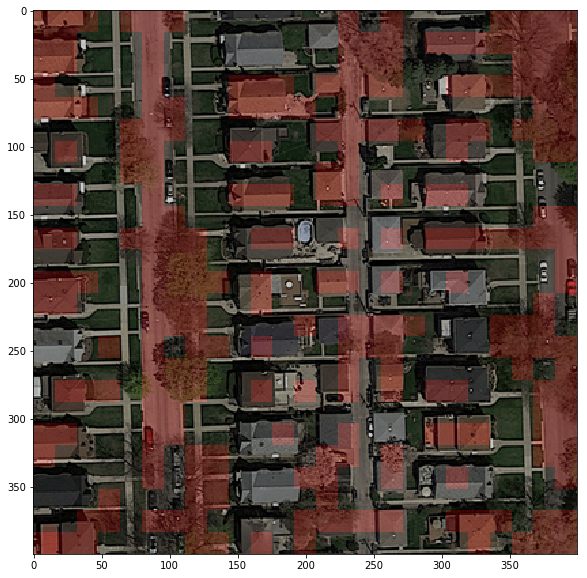

In [19]:
img_idx = 50
X_ = extract_img_features(image_dir + files[img_idx], '3d')
Xx = extract_img_extrafeatures(image_dir + files[img_idx], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)
Zi = lr_model.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

## SVM

In [20]:
from sklearn import svm 

# we create an instance of the classifier and fit the data C = 1/lambda
svm_model = svm.LinearSVC(dual=False, class_weight="balanced")
svm_model.fit(X_train, Y_train)

# Predict on the training set
Z_train = svm_model.predict(X_train)
Z_test = svm_model.predict(X_test)

print_eval(Y_train, Z_train, Y_test, Z_test)

Training set evaluation
             precision    recall  f1-score   support

          0       0.78      0.56      0.66     32430
          1       0.31      0.55      0.39     11320

avg / total       0.66      0.56      0.59     43750

Testing set evaluation
             precision    recall  f1-score   support

          0       0.75      0.55      0.63     13879
          1       0.27      0.48      0.35      4871

avg / total       0.63      0.53      0.56     18750



In [21]:
# # Predict on the testing set
# Z_test = classif.predict(X_test)

# #zt Replace manual caculation for label 1 with the report 
# print("Testing evaluation")
# print(classification_report(Y_test, Z_test))

# #Get non-zeros in prediction and grountruth arrays
# Zn = np.nonzero(Z_test)[0]
# Yn = np.nonzero(Y_test)[0]

# TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
# PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))

# print('True positive rate = ' + str(TPR))
# print('Positive predicted value = ' + str(PPV))
# print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))

Example of image classification from test set:

/Users/ztian/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


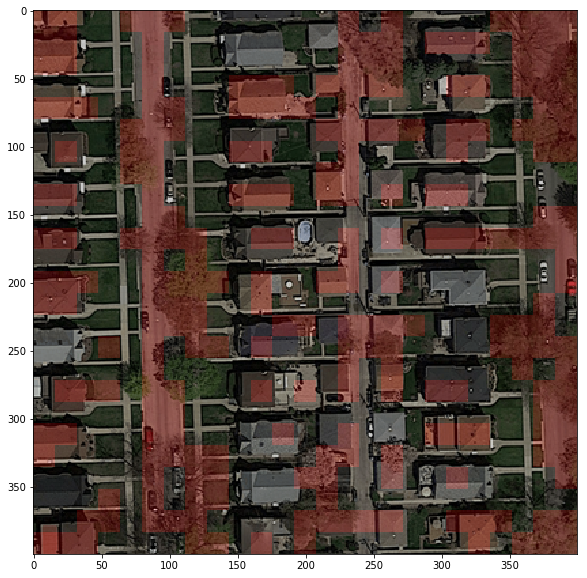

In [22]:
img_idx = 50
X_ = extract_img_features(image_dir + files[img_idx], '3d')
Xx = extract_img_extrafeatures(image_dir + files[img_idx], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)
Zi = svm_model.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)

## KNN

In [21]:
from sklearn import neighbors

knn_model = neighbors.KNeighborsClassifier()
knn_model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
Z_train = knn_model.predict(X_train)
Z_test = knn_model.predict(X_test)
print_eval(Y_train, Z_train, Y_test, Z_test)

## Random Forest Classifier 

In [ ]:
from sklearn import ensemble

classif = ensemble.RandomForestClassifier(100)
classif.fit(X_train, Y_train)

In [ ]:
# Predict on the training set
Z = classif.predict(X_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y_test)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Yn))
PPV = len(list(set(Yn) & set(Zn))) / float(len(Zn))


print('True positive rate = ' + str(TPR))
print('Positive predicted value = ' + str(PPV))
print('F1 score = ' + str(2*PPV*TPR/(TPR+PPV)))


In [ ]:
img_idx = 50
X_ = extract_img_features(image_dir + files[img_idx], '3d')
Xx = extract_img_extrafeatures(image_dir + files[img_idx], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)

Zi = classif.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)



# 4. Generate submission

Load test images

In [ ]:
N_TEST_IMAGES = 50

In [ ]:
# Loaded a set of images
root_test_dir = "test_set_images/"
test_dir = ['test_'+str(i)+'/' for i in range(1,N_TEST_IMAGES+1)]
test_images = ['test_'+str(i)+'.png' for i in range(1,N_TEST_IMAGES+1)]


In [ ]:
submission_filename = 'prediction.csv'

# with open(submission_filename, 'w') as f:
#     f.write('id,prediction\n')
#     for i in range(N_TEST_IMAGES):
#         X_ = extract_img_features(root_test_dir + test_dir[i]+test_images[i], '3d')
#         Xx = extract_img_extrafeatures (root_test_dir + test_dir[i]+test_images[i], extrafeat)
#         Xi = np.concatenate([X_, Xx], axis = 1)
#         Zi = classif.predict(Xi)
    
#         strings=[]
#         count = 0
#         for j in range(0, 608, patch_size):
#             for k in range(0, 608, patch_size):
#                 strings.append("{:03d}_{}_{},{}".format(i+1, j, k, Zi[count]))
#                 count = count + 1


#         f.writelines('{}\n'.format(s) for s in strings)
        

See one test image vs classification:

In [ ]:
X_ = extract_img_features(root_test_dir + test_dir[0]+test_images[0], '3d')
Xx = extract_img_extrafeatures(root_test_dir + test_dir[0]+test_images[0], extrafeat)
Xi = np.concatenate([X_, Xx], axis = 1)

Zi = classif.predict(Xi)
predicted_im = label_to_img(608, 608, patch_size, patch_size, Zi)
im = load_image(root_test_dir + test_dir[0]+test_images[0])
new_img = make_img_overlay(im, predicted_im)

predicted_im.shape
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(new_img)